## Introduction
The goal of this notebook is show how to train a PCA model on AWS Sagemaker. The training data resides on S3 in `s3://skuchkula-sagemaker-airbnb/` location. Objective is to apply Principal Components Analysis (PCA) on airbnb locations located in NYC. 

### STEP 1: Create an S3 bucket which contains sagemaker name in it.
Having the sagemaker name is not a requirement. However, as per Amazon documentation:

> Note: 
Amazon SageMaker needs permission to access these buckets. You grant permission with an IAM role, which you create in the next step when you create an Amazon SageMaker notebook instance. This IAM role automatically gets permissions to access any bucket that has sagemaker in the name. It gets these permissions through the AmazonSageMakerFullAccess policy, which Amazon SageMaker attaches to the role. If you add a policy to the role that grants the SageMaker service principal S3FullAccess permission, the name of the bucket does not need to contain sagemaker.

### STEP 2: Create an Amazon SageMaker Notebook instance
An Amazon SageMaker notebook instance is a fully managed machine learning (ML) Amazon Elastic Compute Cloud (Amazon EC2) compute instance that runs the Jupyter Notebook App. You use the notebook instance to create and manage Jupyter notebooks that you can use to prepare and process data and to train and deploy machine learning models. 

To create an Amazon SageMaker notebook instance

- Open the Amazon SageMaker console at https://console.aws.amazon.com/sagemaker/.

- Choose Notebook instances, then choose Create notebook instance.

- On the Create notebook instance page, provide the following information (if a field is not mentioned, leave the default values):

- For Notebook instance name, type a name for your notebook instance.

- For Instance type, choose ml.t2.medium. This is the least expensive instance type that notebook instances support, and it suffices for this exercise.

- For IAM role, choose Create a new role, then choose Create role.

- Choose Create notebook instance.

In a few minutes, Amazon SageMaker launches an ML compute instance—in this case, a notebook instance—and attaches an ML storage volume to it. The notebook instance has a preconfigured Jupyter notebook server and a set of Anaconda libraries.

### Step 3: Create notebook instance and start writing code

In [3]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# sagemaker libraries
import boto3
import sagemaker

### Step 4:  Get data from S3

In [4]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='skuchkula-sagemaker-airbnb'

In [5]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['detailed_listings.csv', 'summary_listings.csv']


In [6]:
# there is one file --> one key
detailed_listings=files[0]
summary_listings=files[1]

In [8]:
def get_data_frame(bucket_name, file_name):
    # get an S3 object by passing in the bucket and file name
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    
    # information is in the "Body" of the object
    data_body = data_object["Body"].read()
    
    # read in bytes data
    data_stream = io.BytesIO(data_body)
    
    # create a dataframe
    df = pd.read_csv(data_stream, header=0, delimiter=",", low_memory=False)
    
    return df

In [9]:
df_summary_listings = get_data_frame(bucket_name, summary_listings)
df_detailed_listings = get_data_frame(bucket_name, detailed_listings)

In [10]:
df_summary_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,46,2019-07-14,0.39,2,288
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,274,2019-07-26,4.64,1,212
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,75,2019-07-21,0.60,1,127


In [11]:
df_detailed_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20190806030549,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,https://www.airbnb.com/rooms/3647,20190806030549,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,https://www.airbnb.com/rooms/3831,20190806030549,2019-08-06,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,https://www.airbnb.com/rooms/5022,20190806030549,2019-08-06,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,https://www.airbnb.com/rooms/5099,20190806030549,2019-08-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment is true New York ...,none,My neighborhood in Midtown East is called Murr...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


The Detailed listings contains about 106 different features for each of the Airbnb locations. We need to do some EDA to check if we can trim down some features.

In [12]:
print("Summary Listings row, cols: ", df_summary_listings.shape)
print("Detailed Listings row, cols: ", df_detailed_listings.shape)

Summary Listings row, cols:  (48864, 16)
Detailed Listings row, cols:  (48864, 106)


The summary listings contains a small subset of features contained in the detailed listings. Summary listings is good for visualization purposes, but for machine learning models, it is better to have more features from which the model can learn.

In [13]:
df_summary_listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [14]:
# check how the data types are distributed.
# pandas does its best to interpret the datatype while reading in
# however it is our duty to check if the datatype makes sense
df_detailed_listings.dtypes.value_counts()

object     63
float64    22
int64      21
dtype: int64

### Data Cleaning

In [17]:
df_detailed_listings.select_dtypes(include=['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',


In [16]:
print(pd.get_option("display.max_columns"))
pd.set_option("display.max_columns", 100)
print(pd.get_option("display.max_columns"))

20
100


In [18]:
drop_object_cols = ['listing_url',
             'last_scraped',
             'experiences_offered',
             'picture_url',
             'host_url',
             'host_name',
             'host_since',
             'host_location',
             'host_about',
             'host_thumbnail_url',
             'host_picture_url',
             'host_neighbourhood',
             'street',
             'neighbourhood',
             'city',
             'state',
             'zipcode',
             'market',
             'smart_location',
             'country_code',
             'country',
             'calendar_updated',
             'calendar_last_scraped',
             'first_review',
             'last_review' 
            ]

In [19]:
df_detailed_listings.select_dtypes(include=['object']).head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/2595,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",https://a0.muscache.com/im/pictures/f0813a11-4...,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,90%,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",Midtown,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,f,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,"$1,995.00",NaN,$350.00,$100.00,$0.00,a week ago,t,2019-08-07,2009-11-21,2019-07-14,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t
1,https://www.airbnb.com/rooms/3647,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,https://a0.muscache.com/im/pictures/838341/9b3...,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,within a day,100%,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,t,Apartment,Private room,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,NaN,NaN,$200.00,$75.00,$20.00,35 months ago,t,2019-08-06,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t
2,https://www.airbnb.com/rooms/3831,2019-08-06,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,https://a0.muscache.com/im/pictures/e49999c2-9...,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,90%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill

In [20]:
df_detailed_listings.select_dtypes(include=['float64']).columns

Index(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [22]:
drop_float_cols = ['thumbnail_url',
                   'medium_url',
                   'xl_picture_url'
                  ]

In [23]:
df_detailed_listings.select_dtypes(include=['float64']).head()

,thumbnail_url,medium_url,xl_picture_url,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,square_feet,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,NaN,NaN,NaN,NaN,5.0,5.0,40.75362,-73.98377,1.0,0.0,1.0,NaN,1.0,1125.0,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0.39
1,NaN,NaN,NaN,NaN,1.0,1.0,40.80902,-73.94190,1.0,1.0,1.0,NaN,3.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,40.68514,-73.95976,1.0,1.0,4.0,500.0,1.0,730.0,90.0,10.0,9.0,10.0,9.0,10.0,9.0,4.64
3,NaN,NaN,NaN,NaN,1.0,1.0,40.79851,-73.94399,1.0,NaN,1.0,NaN,10.0,120.0,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0.10
4,NaN,NaN,NaN,NaN,1.0,1.0,40.74767,-73.97500,1.0,1.0,1.0,NaN,3.0,21.0,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0.60


In [24]:
df_detailed_listings.select_dtypes(include=['int64']).columns

Index(['id', 'scrape_id', 'host_id', 'accommodates', 'guests_included',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [25]:
drop_int_cols = ['scrape_id',
                 'host_id',
                 'minimum_minimum_nights',
                 'maximum_minimum_nights',
                 'minimum_maximum_nights',
                 'maximum_maximum_nights'
                ]

In [26]:
df_detailed_listings.select_dtypes(include=['int64']).head()

,id,scrape_id,host_id,accommodates,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2595,20190806030549,2845,2,2,1,1125,1,1,1125,1125,13,17,31,288,46,12,2,1,0,1
1,3647,20190806030549,4632,2,2,3,7,3,3,7,7,30,60,90,365,0,0,1,0,1,0
2,3831,20190806030549,4869,3,1,1,730,1,1,730,730,0,1,4,212,274,70,1,1,0,0
3,5022,20190806030549,7192,1,1,10,120,10,10,120,120,0,0,0,0,9,2,1,1,0,0
4,5099,20190806030549,7322,2,2,3,21,3,3,21,21,24,33,63,127,75,10,1,1,0,0


In [27]:
drop_cols = drop_object_cols + drop_float_cols + drop_int_cols
len(drop_cols)

34

In [28]:
drop_cols

['listing_url',
 'last_scraped',
 'experiences_offered',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'street',
 'neighbourhood',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'calendar_updated',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'scrape_id',
 'host_id',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights']

In [29]:
df_dl_clean_df = df_detailed_listings.drop(columns=drop_cols)

In [30]:
df_dl_clean_df.shape

(48864, 72)

## Missing Value analysis
Calculate missing value statistics

In [31]:
print(pd.get_option("display.max_rows"))
pd.set_option("display.max_rows", 100)
print(pd.get_option("display.max_rows"))

60
100


In [ ]:
[
    'host_acceptance_rate', 
    'jurisdiction_names',
    'license',
    'square_feet',
    'monthly_price',
    'weekly_price',
    'notes',
    'access',
    'interaction',
    
]

In [32]:
num_missing = df_dl_clean_df.isnull().sum().to_frame()
num_missing.columns = ['num_missing']
num_missing['pct_missing'] = np.round(100 * (num_missing['num_missing'] / df_dl_clean_df.shape[0]))
num_missing.sort_values(by='num_missing', ascending=False)

,num_missing,pct_missing
host_acceptance_rate,48864,100.0
jurisdiction_names,48853,100.0
license,48842,100.0
square_feet,48469,99.0
monthly_price,43715,89.0
weekly_price,42964,88.0
notes,28692,59.0
access,21916,45.0
interaction,19947,41.0
house_rules,18912,39.0


Drop all columns which have missing values greater than 10,000

In [52]:
cols_to_drop = list(num_missing[num_missing.pct_missing > 20].index)

In [53]:
cols_to_drop

['space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'reviews_per_month']

In [54]:
df_dl_clean_df.shape

(48864, 72)

In [55]:
df_dl_clean_df = df_dl_clean_df.drop(cols_to_drop, axis='columns')

In [56]:
df_dl_clean_df.shape

(48864, 47)

In [57]:
df_dl_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Data columns (total 47 columns):
id                                              48864 non-null int64
name                                            48848 non-null object
summary                                         46789 non-null object
description                                     48021 non-null object
host_is_superhost                               48846 non-null object
host_listings_count                             48846 non-null float64
host_total_listings_count                       48846 non-null float64
host_verifications                              48864 non-null object
host_has_profile_pic                            48846 non-null object
host_identity_verified                          48846 non-null object
neighbourhood_cleansed                          48864 non-null object
neighbourhood_group_cleansed                    48864 non-null object
latitude                                        48

Out of these we need to check which ones are categorical variables. So, lets start by collecting all the object data types. 

In [62]:
df_dl_clean_df.select_dtypes(['object']).head()

,name,summary,description,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,bed_type,amenities,price,extra_people,has_availability,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",f,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,f,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,$0.00,t,f,f,f,strict_14_with_grace_period,t,t
1,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,f,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Harlem,Manhattan,t,Apartment,Private room,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,$20.00,t,f,f,f,strict_14_with_grace_period,t,t
2,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,f,"['email', 'phone', 'reviews', 'kba']",t,t,Clinton Hill,Brooklyn,t,Guest suite,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$89.00,$0.00,t,f,f,f,moderate,f,f
3,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,t,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,$20.00,t,f,f,f,strict_14_with_grace_period,t,t
4,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,f,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,$100.00,t,f,f,f,strict_14_with_grace_period,t,t


By inspecting these variables, we can clearly see that some of these object types are actually categorical variables and some are boolean variables. Our goal is to convert them to categorical variables first and then use the `pd.dummies()` to create one-hot encoded version of these columns.

In [64]:
# collect all variables which need to be dummy encoded.
need_dummy_encoding = [
    'host_is_superhost', 
    'host_has_profile_pic', 
    'host_identity_verified',
    'is_location_exact',
    'property_type',
    'room_type',
    'bed_type',
    'has_availability',
    'requires_license',
    'instant_bookable',
    'is_business_travel_ready',
    'cancellation_policy',
    'require_guest_profile_picture',
    'require_guest_phone_verification']

In [65]:
# before converting to category
print(df_dl_clean_df[need_dummy_encoding].dtypes)

host_is_superhost                   object
host_has_profile_pic                object
host_identity_verified              object
is_location_exact                   object
property_type                       object
room_type                           object
bed_type                            object
has_availability                    object
requires_license                    object
instant_bookable                    object
is_business_travel_ready            object
cancellation_policy                 object
require_guest_profile_picture       object
require_guest_phone_verification    object
dtype: object


In [66]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_values = df_dl_clean_df[need_dummy_encoding].apply(pd.Series.nunique, axis='rows')

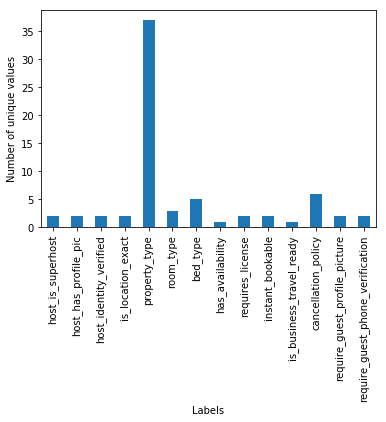

In [68]:
# Plot number of unique values for each label
num_unique_values.plot(kind='bar')
# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

In [69]:
num_unique_values

host_is_superhost                    2
host_has_profile_pic                 2
host_identity_verified               2
is_location_exact                    2
property_type                       37
room_type                            3
bed_type                             5
has_availability                     1
requires_license                     2
instant_bookable                     2
is_business_travel_ready             1
cancellation_policy                  6
require_guest_profile_picture        2
require_guest_phone_verification     2
dtype: int64

In [71]:
df_dl_clean_df.room_type.value_counts()

Entire home/apt    25296
Private room       22397
Shared room         1171
Name: room_type, dtype: int64

In [70]:
df_dl_clean_df.property_type.value_counts()

Apartment                 38605
House                      3846
Townhouse                  1659
Condominium                1495
Loft                       1412
Serviced apartment          505
Guest suite                 363
Hotel                       227
Boutique hotel              190
Other                       118
Bed and breakfast            88
Resort                       72
Hostel                       62
Guesthouse                   56
Bungalow                     38
Villa                        28
Tiny house                   19
Aparthotel                   17
Boat                         13
Camper/RV                    10
Cottage                       7
Tent                          6
Earth house                   4
Cabin                         3
Houseboat                     3
Cave                          2
Farm stay                     2
Casa particular (Cuba)        2
Bus                           2
Yurt                          2
Barn                          2
Nature l

At this point, we need to ask ourselves, whether we really want to focus on specific property types instead of using all the data. Since comparing some unique property types like Tent, Barn, Lighthouse are going to skew our data.

In [75]:
df_dl_clean_df[df_dl_clean_df.property_type == 'Apartment'].shape

(38605, 47)

In [76]:
df_dl_clean_df[df_dl_clean_df.property_type == 'Apartment'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38605 entries, 0 to 48863
Data columns (total 47 columns):
id                                              38605 non-null int64
name                                            38589 non-null object
summary                                         36999 non-null object
description                                     37973 non-null object
host_is_superhost                               38589 non-null object
host_listings_count                             38589 non-null float64
host_total_listings_count                       38589 non-null float64
host_verifications                              38605 non-null object
host_has_profile_pic                            38589 non-null object
host_identity_verified                          38589 non-null object
neighbourhood_cleansed                          38605 non-null object
neighbourhood_group_cleansed                    38605 non-null object
latitude                                        38

In [58]:
df_dl_clean_df.head()

,id,name,summary,description,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2595,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,2,$0.00,1,1125,1.0,1125.0,t,13,17,31,288,46,12,f,f,f,strict_14_with_grace_period,t,t,2,1,0,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,f,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Harlem,Manhattan,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,2,$20.00,3,7,3.0,7.0,t,30,60,90,365,0,0,f,f,f,strict_14_with_grace_period,t,t,1,0,1,0
2,3831,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Clinton Hill,Brooklyn,40.68514,-73.95976,t,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$89.00,1,$0.00,1,730,1.0,730.0,t,0,1,4,212,274,70,f,f,f,moderate,f,f,1,1,0,0
3,5022,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,NaN,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,1,$20.00,10,120,10.0,120.0,t,0,0,0,0,9,2,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,2,$100.00,3,21,3.0,21.0,t,24,33,63,127,75,10,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0


In [59]:
df_dl_clean_df['cancellation_policy'].value_counts()

strict_14_with_grace_period    21948
flexible                       15408
moderate                       11368
super_strict_60                  111
super_strict_30                   23
strict                             5
Name: cancellation_policy, dtype: int64

In [60]:
df_dl_clean_df['bed_type'].value_counts()

Real Bed         48076
Futon              294
Pull-out Sofa      250
Airbed             172
Couch               72
Name: bed_type, dtype: int64

## Analyze amenities

In [30]:
df_dl_clean_df['amenities'] =  df_dl_clean_df['amenities'].apply(lambda x: x[1:-1])

In [31]:
amenities = df_dl_clean_df['amenities']

In [32]:
amenities_idx ={}
idx = 0
corpus = []
for i in range(len(amenities)):
    items = amenities[i]
    items_lower = items.lower()
    tokens = items_lower.split(',')
    corpus.append(tokens)
    for token in tokens:
        if token not in amenities_idx:
            amenities_idx[token] = idx
            idx += 1

In [33]:
len(amenities_idx)

131

In [34]:
len(corpus)

48864

In [35]:
# Get the number of items and tokens 
M = len(amenities)
N = len(amenities_idx)

# Initialize a matrix of zeros
A = np.zeros((M, N))

In [36]:
# Define the amenity_encoder function
def amenity_encoder(tokens):
    x = np.zeros(N)
    for token in tokens:
        # Get the index for each amenity
        idx = amenities_idx[token]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x

In [37]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = amenity_encoder(tokens)
    i = i + 1

In [38]:
A.shape

(48864, 131)

In [40]:
from sklearn.manifold import TSNE

In [ ]:
# Dimension reduction with t-SNE
model = TSNE(n_components=2, learning_rate=200, random_state=42)
tsne_features = model.fit_transform(A)

In [42]:
tsne_df = pd.DataFrame({'TSNE1': tsne_features[:,0], 
              'TSNE2': tsne_features[:,1]
             })

In [43]:
subset_cols = ['id', 'price', 'amenities', 
               'neighbourhood_cleansed', 
               'neighbourhood_group_cleansed',
               'latitude', 'longitude'
              ]

In [44]:
df_dl_clean_df = df_dl_clean_df[subset_cols]

In [45]:
df_dl_clean_df = pd.concat([df_dl_clean_df, tsne_df], axis='columns')

In [46]:
df_dl_clean_df.head()

,id,price,amenities,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,TSNE1,TSNE2
0,2595,$225.00,"TV,Wifi,""Air conditioning"",Kitchen,""Paid parki...",Midtown,Manhattan,40.75362,-73.98377,42.803360,-10.623417
1,3647,$150.00,"""Cable TV"",Internet,Wifi,""Air conditioning"",Ki...",Harlem,Manhattan,40.80902,-73.94190,-34.314285,13.559643
2,3831,$89.00,"TV,""Cable TV"",Internet,Wifi,""Air conditioning""...",Clinton Hill,Brooklyn,40.68514,-73.95976,3.406300,-22.669363
3,5022,$80.00,"Internet,Wifi,""Air conditioning"",Kitchen,Eleva...",East Harlem,Manhattan,40.79851,-73.94399,-11.913917,-8.425117
4,5099,$200.00,"TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/wi...",Murray Hill,Manhattan,40.74767,-73.97500,-12.099396,-1.838848


In [47]:
df_dl_clean_df.to_csv('tsne-results.csv', index=False)

### Visualizing t-sne results

In [88]:
from bokeh.io import show, output_notebook, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()


Loading BokehJS ...

In [97]:
# Make a source and a scatter plot  
source = ColumnDataSource(df_dl_clean_df[:100])

In [98]:
plot = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot.circle(x = 'TSNE1', 
    y = 'TSNE2', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

GlyphRenderer(id='1408', ...)

In [99]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('id', '@id'),
                              ('price', '$@price')
                             ])
plot.add_tools(hover)

In [100]:
output_file('amenities.html')
show(plot)

## To do

In [ ]:
# more columns that can be removed
# experiences_offered, contains all none's so no use.
more_cols = ['experiences_offered']